<a href="https://colab.research.google.com/github/arijitaurko/See-in-the-Dark-using-CNN/blob/main/Learning_to_See_in_the_Dark_Classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rawpy
!pip install bm3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, requests, os, random, time, glob, rawpy, imageio
from google.colab import drive
from PIL import Image
import bm3d, cv2

%matplotlib inline

In [1]:
!mkdir dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget https://storage.googleapis.com/isl-datasets/SID/Sony.zip -O '/content/dataset/Sony.zip'

--2023-09-07 03:09:52--  https://storage.googleapis.com/isl-datasets/SID/Sony.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.202.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26926662016 (25G) [application/zip]
Saving to: ‘/content/dataset/Sony.zip’

/content/dataset/So 100%[===================>]  25.08G  49.6MB/s    in 5m 36s  

2023-09-07 03:15:28 (76.4 MB/s) - ‘/content/dataset/Sony.zip’ saved [26926662016/26926662016]



In [ ]:
#!unzip -q /content/dataset/Sony.zip -d /content/drive/MyDrive/DSML_Portfolio_Project/dataset/

In [ ]:
#!rm /content/dataset/Sony.zip

In [ ]:
!du -sh /content/drive/MyDrive/DSML_Portfolio_Project/dataset/

68G	/content/drive/MyDrive/DSML_Portfolio_Project/dataset/


In [ ]:
BASE_PATH = '/content/drive/MyDrive/DSML_Portfolio_Project/dataset/'

# Data Input and Pre-Processing

1. post_process_raw()
2. read_image() & read_label()

In [ ]:
data_train = pd.read_csv(BASE_PATH + 'Sony_train_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])
data_test = pd.read_csv(BASE_PATH + 'Sony_test_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])
data_val = pd.read_csv(BASE_PATH + 'Sony_val_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])

data_train['x'] = BASE_PATH + data_train['x'].str.lstrip('.')
data_train['y'] = BASE_PATH + data_train['y'].str.lstrip('.')
print('Train : ', data_train.shape)

data_test['x'] = BASE_PATH + data_test['x'].str.lstrip('.')
data_test['y'] = BASE_PATH + data_test['y'].str.lstrip('.')
print('Test : ', data_test.shape)

data_val['x'] = BASE_PATH + data_val['x'].str.lstrip('.')
data_val['y'] = BASE_PATH + data_val['y'].str.lstrip('.')
print('Val : ', data_val.shape)

Train :  (1865, 4)
Test :  (598, 4)
Val :  (234, 4)


In [ ]:
data_train.head(10)

,x,y,iso,f
0,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
1,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
2,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
3,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
4,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
5,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
6,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
7,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
8,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8
9,/content/drive/MyDrive/DSML_Portfolio_Project/...,/content/drive/MyDrive/DSML_Portfolio_Project/...,ISO200,F8


In [ ]:
def _read_image(path):
    with rawpy.imread(path) as raw:
        rgb_image = raw.postprocess()
    return rgb_image

In [ ]:
def read_raw(path):
  return rawpy.imread(path)

def post_process_raw(raw, output_bps = 16):
  # Unify both in case of same channels and resize
  nm = 65535.0
  img = raw.postprocess(use_camera_wb = True, no_auto_bright = True, output_bps = output_bps)
  img = np.float32(img) / nm
  return img

def plot_pair(x, y):
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    ax[0].imshow(x)
    ax[1].imshow(y)
    plt.tight_layout()
    plt.show()

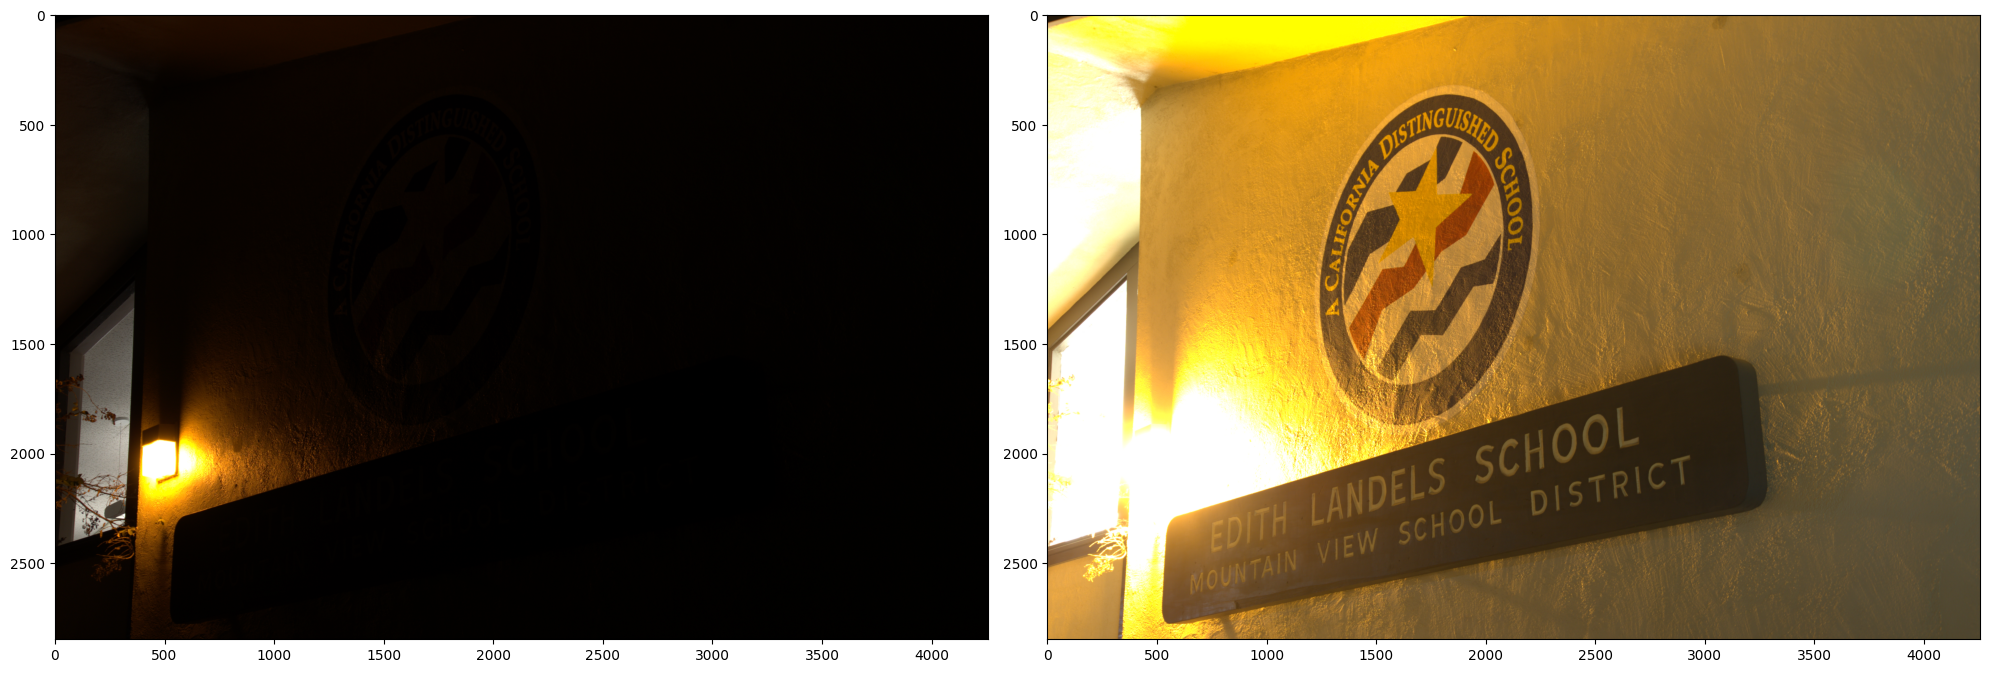

In [ ]:
temp_x = data_train['x'][300]
temp_y = data_train['y'][300]

im1 = read_raw(temp_x)
im1 = post_process_raw(im1)

im2 = read_raw(temp_y)
im2 = post_process_raw(im2)

fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(im1)
ax[1].imshow(im2)
plt.tight_layout()
plt.show()

# Classical Image Processing for Low-Light Enhancement

1. Denoising using **BM3D** (Block Matching and 3D Filtering)

In [ ]:
def PSNR_Classical(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def SSIM_Classical(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def Calculate_SSIM(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return SSIM_Classical(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(SSIM_Classical(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return SSIM_Classical(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
denoised_image = bm3d.bm3d(im1, sigma_psd = 0.3, stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)

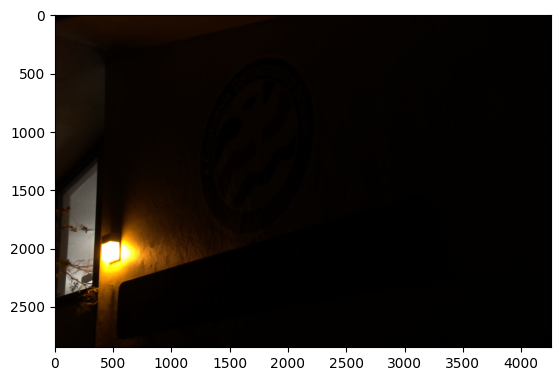

In [ ]:
plt.imshow(denoised_image)

2. Further Enhancing the Image by Enhancing Brightness and Contrast

In [ ]:
enhanced = cv2.convertScaleAbs(denoised_image, alpha = 200, beta = 30)
sharpened_image = cv2.medianBlur(enhanced, 11)

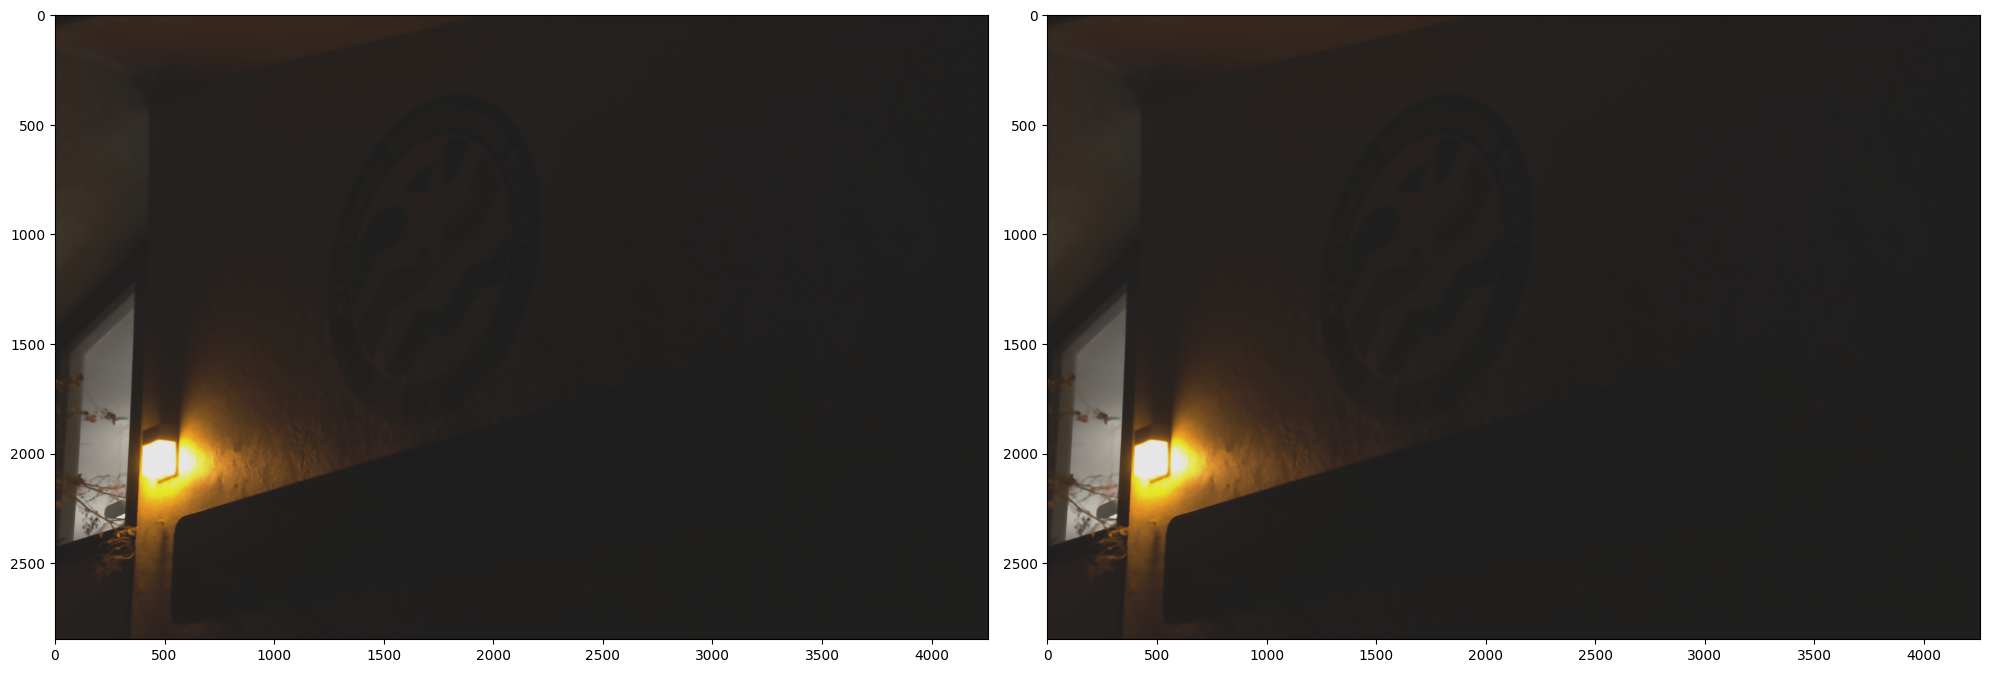

In [ ]:
plot_pair(enhanced, sharpened_image)

In [ ]:
print('PSNR: ', PSNR_Classical(im2, sharpened_image), ', SSIM: ', Calculate_SSIM(im2, sharpened_image))

PSNR:  15.641365407995625 , SSIM:  0.029829512681135834


3. **Image Dehazing** using **Improved Dark Channel** and **Atmosphere Scattering**

In [ ]:
from itertools import combinations_with_replacement
from collections import defaultdict
from numpy.linalg import inv

B, G, R = 0, 1, 2  # index for convenience

def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """
    M, N = I.shape
    dest = np.zeros((M, N))
    #print(I)

    # cumulative sum over Y axis (tate-houkou no wa)
    sumY = np.cumsum(I, axis=0)
    #print('sumY:{}'.format(sumY))
    # difference over Y axis
    dest[:r + 1] = sumY[r:2*r + 1] # top r+1 lines
    dest[r + 1:M - r] = sumY[2*r + 1:] - sumY[:M - 2*r - 1]
    #print(sumY[2*r + 1:]) # from 2*r+1 to end lines
    #print(sumY[:M - 2*r - 1]) # same lines of above, from start
    #tile replicate sumY[-1] and line them up to match the shape of (r, 1)
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2*r - 1:M - r - 1] # bottom r lines

    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    #print('sumX:{}'.format(sumX))
    # difference over X axis
    dest[:, :r + 1] = sumX[:, r:2*r + 1] # left r+1 columns
    dest[:, r + 1:N - r] = sumX[:, 2*r + 1:] - sumX[:, :N - 2*r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2*r - 1:N - r - 1] # right r columns

    #print(dest)

    return dest


def guided_filter(I, p, r=15, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided. transmission is used for this case.
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r) # this is needed for regularization

    # each channel of I filtered with the mean filter. this is myu.
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]

    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base

    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i]*p, r) / base for i in range(3)]

    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i]*mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(I[:, :, i]*I[:, :, j], r) / base - means[i]*means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[B][B][y, x], var[B][G][y, x], var[B][R][y, x]],
                          [var[B][G][y, x], var[G][G][y, x], var[G][R][y, x]],
                          [var[B][R][y, x], var[G][R][y, x], var[R][R][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps*np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R]*means[R] - a[:, :, G]*means[G] - a[:, :, B]*means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r)*I[:, :, R] + boxfilter(a[:, :, G], r)*I[:, :, G] + boxfilter(a[:, :, B], r)*I[:, :, B] + boxfilter(b, r)) / base

    return q

In [ ]:
def get_illumination_channel(I, w):
    M, N, _ = I.shape
    padded = np.pad(I, ((int(w/2), int(w/2)), (int(w/2), int(w/2)), (0, 0)), 'edge')
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))

    for i, j in np.ndindex(darkch.shape):
        darkch[i, j] = np.min(padded[i:i + w, j:j + w, :])
        brightch[i, j] = np.max(padded[i:i + w, j:j + w, :])

    return darkch, brightch

def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3)
    flatbright = brightch.ravel()

    searchidx = (-flatbright).argsort()[:int(M*N*p)]
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A

def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch-A_c)/(1.-A_c)
    return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t))

def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
    im3 = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        im3[:, :, ind] = I[:, :, ind] / A[ind]
    dark_c, _ = get_illumination_channel(im3, w)
    dark_t = 1 - omega*dark_c
    corrected_t = init_t
    diffch = brightch - darkch

    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if(diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]

    return np.abs(corrected_t)

def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3))
    J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A

    return (J - np.min(J))/(np.max(J) - np.min(J))

def dehaze(I, tmin, w, alpha, omega, p, eps, reduce=False):
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
    A = get_atmosphere(I, Ibright, p)

    init_t = get_initial_transmission(A, Ibright)
    if reduce:
        init_t = reduce_init_t(init_t)
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega, w)

    normI = (I - I.min()) / (I.max() - I.min())
    refined_t = guided_filter(normI, corrected_t, w, eps)
    J_refined = get_final_image(I, A, refined_t, tmin)

    enhanced = (J_refined*255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced, flags=1, sigma_s=64, sigma_r=0.2)
    return f_enhanced

def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8)
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    init_t = cv2.LUT(init_t, table)
    init_t = init_t.astype(np.float64)/255
    return init_t

#im = cv2.imread('dark.png')
#orig = im.copy()

tmin = 0.1   # minimum value for t to make J image
w = 15       # window size, which determine the corseness of prior images
alpha = 0.4  # threshold for transmission correction
omega = 0.75 # this is for dark channel prior
p = 0.1      # percentage to consider for atmosphere
eps = 1e-3   # for J image

#I = np.asarray(im, dtype=np.float64) # Convert the input to an array.
I = im1
orig = im1.copy()
I = I[:, :, :3] / 255

f_enhanced = dehaze(I, tmin, w, alpha, omega, p, eps)
f_enhanced2 = dehaze(I, tmin, w, alpha, omega, p, eps, True)

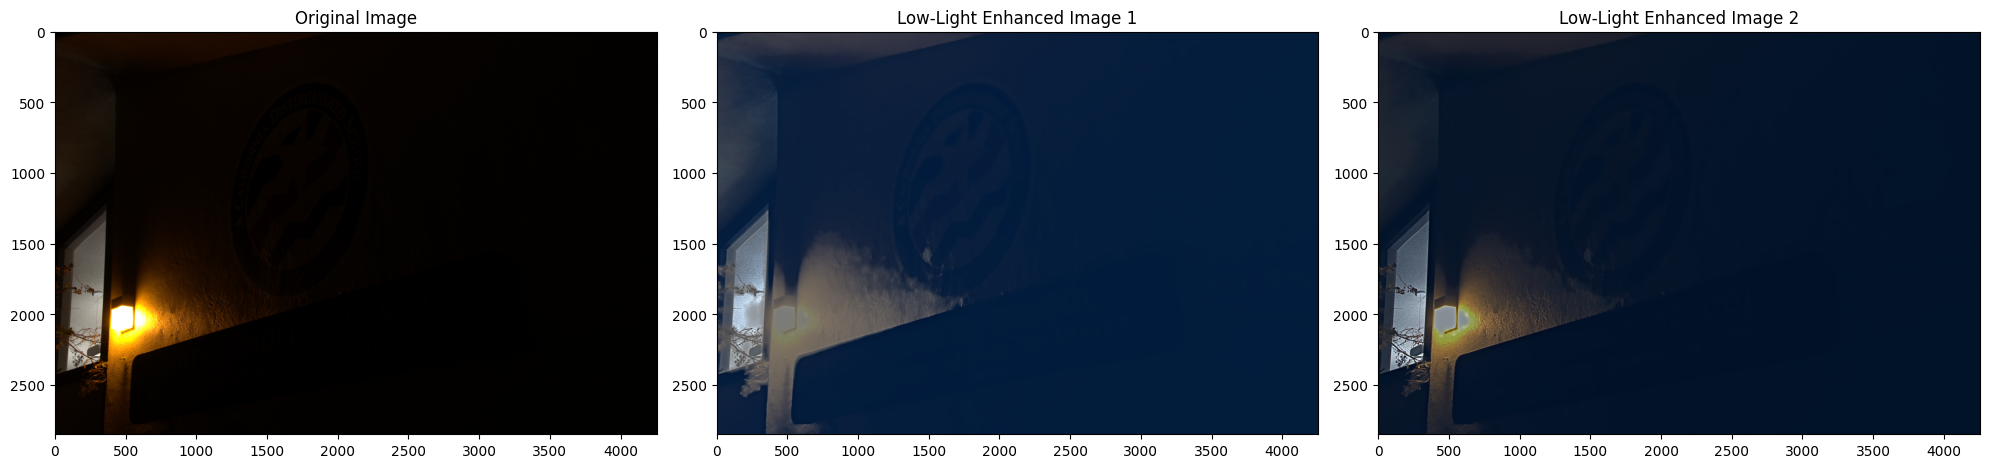

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (20, 10))
ax[0].imshow(orig)
ax[0].set_title('Original Image')
ax[1].imshow(f_enhanced)
ax[1].set_title('Low-Light Enhanced Image 1')
ax[2].imshow(f_enhanced2)
ax[2].set_title('Low-Light Enhanced Image 2')
plt.tight_layout()
plt.show()

In [ ]:
print('PSNR: ', PSNR_Classical(im2, f_enhanced2), ', SSIM: ', Calculate_SSIM(im2, f_enhanced2))

PSNR:  17.096091209299228 , SSIM:  0.20323115377120762
